In [1]:
# download the dataset
file = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
!wget $file -O ../data/car-price.csv

--2023-10-01 22:52:29--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1,4M) [text/plain]
Saving to: ‘../data/car-price.csv’

../data/car-price.c 100%[===================>]   1,41M  1,69MB/s    in 0,8s    

2023-10-01 22:52:30 (1,69 MB/s) - ‘../data/car-price.csv’ saved [1475504/1475504]



In [296]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error


FEATURES = [
    "Make", "Model", "Year", "Engine HP",
    "Engine Cylinders", "Transmission Type",
    "Vehicle Style", "highway MPG", "city mpg"
]

TARGET = "MSRP"
SEED = 42

df = pd.read_csv("../data/car-price.csv", usecols=FEATURES+[TARGET])
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.rename(columns={"msrp": "price"})
df.fillna(value=0, inplace=True)

#### Question 1. What is the most frequent observation (mode) for the column transmission_type?
AUTOMATIC

<Axes: >

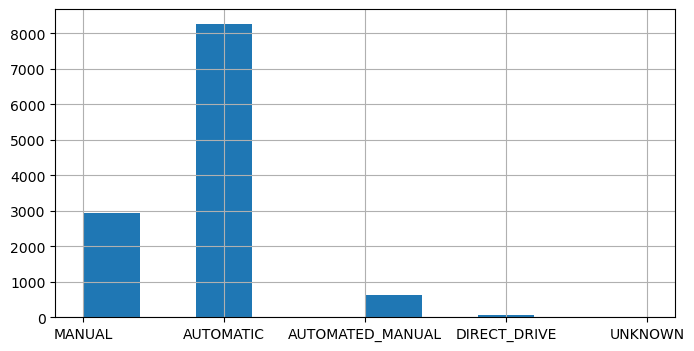

In [297]:
df.transmission_type.hist(figsize=(8, 4))

#### Question 2. What are the two features that have the biggest correlation in this dataset?
highway_mpg and city_mpg

In [298]:
numeric = list(df.dtypes[df.dtypes.isin(["int64", "float64"])].index)
df[numeric].corr()

,year,highway_mpg,city_mpg,price
year,1.000000,0.258240,0.198171,0.227590
highway_mpg,0.258240,1.000000,0.886829,-0.160043
city_mpg,0.198171,0.886829,1.000000,-0.157676
price,0.227590,-0.160043,-0.157676,1.000000


In [299]:
# make price binary
df["above_average"] = df.price > df.price.mean()

In [300]:
# split the data
df_train_full, df_test = train_test_split(df, test_size=.2, random_state=SEED)
df_train, df_val = train_test_split(df_train_full, test_size=.33, random_state=SEED)

y_train = df_train.above_average.values
y_val = df_val.above_average.values

y_train_price = np.log1p(df_train.price.values)
y_val_price = np.log1p(df_val.price.values)

df_train.drop([
    #"price",
    "above_average"], axis=1, inplace=True)
df_val.drop([
    #"price", 
    "above_average"], axis=1, inplace=True)

#### Question 3. Which of these variables has the lowest mutual information score?
transmission_type

In [301]:
categorical = list(df.dtypes[df.dtypes=="object"].index)


def calculate_mi(series):
    return mutual_info_score(series, y_train)


df_mi = df_train[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

In [302]:
df_mi

,MI
model,0.464453
make,0.239861
vehicle_style,0.084913
transmission_type,0.020512


#### Question 4. What accuracy did you get?
0.94

In [303]:
# train_dict = df_train[categorical + numeric[:-1]].to_dict(orient="records")
train_dict = df_train[categorical].to_dict(orient="records")
dv = DictVectorizer(sparse=True)
dv.fit(train_dict)
X_train = dv.transform(train_dict)
model = LogisticRegression(solver="liblinear", C=10, max_iter=1000, random_state=SEED)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [304]:
categorical

['make', 'model', 'transmission_type', 'vehicle_style']

In [305]:
val_dict = df_val[categorical].to_dict(orient="records")
X_val = dv.transform(val_dict)

In [306]:
y_pred = model.predict(X_val)

In [307]:
round(accuracy_score(y_val, y_pred), 2)

0.94

#### Question 5. Which of following feature has the smallest difference?
year

In [308]:
cols = categorical + numeric[:-1]
train_dict = df_train[cols].to_dict(orient="records")
dv = DictVectorizer(sparse=True)
dv.fit(train_dict)
X_train = dv.transform(train_dict)
model = LogisticRegression(solver="liblinear", C=10, max_iter=1000, random_state=SEED)
model.fit(X_train, y_train)
val_dict = df_val[cols].to_dict(orient="records")
X_val = dv.transform(val_dict)
    
y_pred = model.predict(X_val)
original = round(accuracy_score(y_val, y_pred), 2)

params = dict(zip(cols, [None] * len(cols)))

for k in params.keys():
    cols = [c for c in categorical + numeric[:-1] if c != k]
    train_dict = df_train[cols].to_dict(orient="records")
    dv = DictVectorizer(sparse=True)
    dv.fit(train_dict)
    X_train = dv.transform(train_dict)
    model = LogisticRegression(solver="liblinear", C=10, max_iter=1000, random_state=SEED)
    model.fit(X_train, y_train)
    val_dict = df_val[cols].to_dict(orient="records")
    X_val = dv.transform(val_dict)
    
    y_pred = model.predict(X_val)
    params[k] = round(accuracy_score(y_val, y_pred), 2)

In [309]:
params

{'make': 0.92,
 'model': 0.86,
 'transmission_type': 0.91,
 'vehicle_style': 0.9,
 'year': 0.94,
 'highway_mpg': 0.93,
 'city_mpg': 0.93}

In [312]:
for k, v in params.items():
    print(F"{k}: {round(0.95 - v, 2)}")

make: 0.03
model: 0.09
transmission_type: 0.04
vehicle_style: 0.05
year: 0.01
highway_mpg: 0.02
city_mpg: 0.02


#### Question 6. Which of these alphas leads to the best RMSE on the validation set?
0.1

In [313]:
cols = categorical + numeric[:-1]
alpha = [0, 0.01, 0.1, 1, 10]
train_dict = df_train[cols].to_dict(orient="records")
dv = DictVectorizer(sparse=True)
dv.fit(train_dict)
X_train = dv.transform(train_dict)
val_dict = df_val[cols].to_dict(orient="records")
X_val = dv.transform(val_dict)

In [314]:
result = dict(zip(alpha, [None] * len(alpha)))
for a in alpha:
    rr = Ridge(alpha=a, solver="sag", random_state=SEED)
    rr.fit(X_train, y_train_price)
    y_pred = rr.predict(X_val)
    result[a] = mean_squared_error(y_val_price, y_pred, squared=False)

In [315]:
result

{0: 0.24391072672705416,
 0.01: 0.24249229415545245,
 0.1: 0.24016651397537564,
 1: 0.2498253866860999,
 10: 0.3518338479348105}

In [316]:
for k, v in result.items():
    print(k, round(v, 3))

0 0.244
0.01 0.242
0.1 0.24
1 0.25
10 0.352
